## Algorithmic Data Science Assignment

In [ ]:
import time
import math
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.stats as stats
from multiprocessing import Pool
from collections import defaultdict
import nltk
from nltk import word_tokenize
from nltk.corpus import words
from nltk.corpus import brown
nltk.download('brown')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Take a list of random words from NLTK to create the documents. The sencond list will be the same but adding an 'a' so as to use completely different documents with the same size for the worst case running time in jaccard's similarity. 

In [ ]:
news_words = random.sample(words.words(), 50000)
news_words2 = [word + 'a' for word in news_words]

Create two lists that contains 100 samples of random words of different length.

In [ ]:
samples = list(map(int, np.linspace(50, 2000, 100)))
samples_news = [random.sample(news_words,s) for s in samples]
samples_news2 = [random.sample(news_words2,s) for s in samples]

Create two collections of documents encoded as sparse representations. Each collection contains 100 documents that do not have any word in common (recall the 'a' added to obtain two complitely different documents).

In [ ]:
def create_document(tokens):
  mydict = {}
  for token in tokens:
    mydict[token] = mydict.get(token,0) + 1
      
  return mydict

def create_collection(samples):
  docs = []
  for words in samples:
    docs.append(create_document(words))

  return docs
    
docs_news = create_collection(samples_news)
docs_news2 = create_collection(samples_news2)

Take the function 'timeit' from the labs to measure the average running time of different algorithms. 

In [ ]:
def timeit(somefunc,*args,repeats=100,**kwargs):
    times=[]
    for i in range(repeats):
        starttime=time.time()
        ans=somefunc(*args,**kwargs)
        endtime=time.time()
        timetaken=endtime-starttime
        times.append(timetaken)
    
    mean=np.mean(times)
    stdev=np.std(times)
    error=stdev/(repeats**0.5)
 
    return (ans,mean,error)

# Question 1: Jaccard Similarity

$$Jaccard(A,B) = \cfrac{|A\cap B|}{|A\cup B|}$$

Jaccard's similarity between two documents is computed by iterating over all the words in one document and check whether that word is present in the other document. To check that, it is used the 'in' operation (e.g., if x in y). Although on average the running time of this operation is constant ($O(1)$), its worst case scenario  is a linear time complexity $O(n)$, which is the case when there are no elements in the intersection (the loop has to iterate over all the words of the second document). Thus, in the worst case scenario, the time complexity of Jaccard's similarity is $O(n\times n)$, which is quadratic: $O(n^2)$.

To empirically show that this is the case, I have added an extra boolean parameter to the function 'jaccard_similarity' called 'worst_case' which, when it is set to true, it is substituted the 'in' operation for another loop, resulting in a nested loop whose time complexity is $O(n^2)$. 

In [ ]:
def maketotal(dict1):
    total = 0
    for item in dict1:
      total += dict1[item]
      
    return total

def jaccard_similarity(dict1,dict2,worst_case=False):
    intersection = {}
    for item1 in dict1.keys():
      if worst_case:
        for item2 in dict2.keys():
            if item1 == item2:
              intersection[item1] = min(dict1[item1],dict2[item1]) 
      else:
        if item1 in dict2.keys():
          intersection[item1] = min(dict1[item1],dict2[item1])
            
    intersectiontot = maketotal(intersection)
    union = maketotal(dict1) + maketotal(dict2) - intersectiontot

    return intersectiontot / union

Measure running time of Jaccard similarity between different sparse representations length. The first one is for the average case running time, which is $O(n)$, and the second for the worst case running time, which is $O(n^2)$. In order to get the worst case scenario, the documents compared don't have any word in common. Thus, there are zero elements in the intersection. For the average case, the documents compared are the same, which should not have any impact in the final result. 

In [ ]:
times_jaccard = []
for ind in range(len(docs_news)):
  times_jaccard.append(timeit(jaccard_similarity, docs_news[ind], docs_news[ind])[1])

In [ ]:
times_jaccard2 = []
for ind in range(len(docs_news)):
  times_jaccard2.append(timeit(jaccard_similarity, docs_news[ind], docs_news2[ind],True)[1])

Get x-values (sparse representations length) and y-values (running time).


In [ ]:
xs_jaccard = [len(d) for d in docs_news]
ys_jaccard = times_jaccard
ys_jaccard2 = times_jaccard2

Plot running times for Jaccard similarity in the average and worst case. 

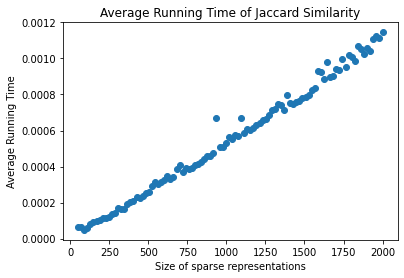

In [ ]:
plt.scatter(xs_jaccard,ys_jaccard)
plt.title('Average Running Time of Jaccard Similarity')
plt.xlabel('Size of sparse representations')
plt.ylabel('Average Running Time')
plt.show()

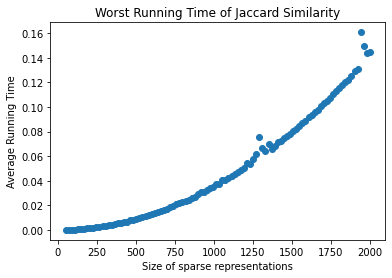

In [ ]:
plt.scatter(xs_jaccard,ys_jaccard2)
plt.title('Worst Running Time of Jaccard Similarity')
plt.xlabel('Size of sparse representations')
plt.ylabel('Average Running Time')
plt.show()

In order to find the constant ($c$) and the gradient ($n$), I assume that the function type is the following: 
$$y=c\cdot x^n$$ 
Then, I convert this to logarithms in order to find the slope and the constant:
$$\log(y) = \log(c) + n \log(x)$$

Scatter plot of the data points along with a plot of the linear regression using scipy.stats.

Using linear regression from scipy.stats:
Slope = 0.9501453601431287
Intercept = -6.115580747395885


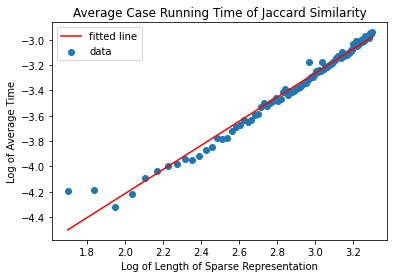

In [ ]:
def plot_data_linregr(xs, ys, case='Worst', type_repr="Sparse", similarity="Jaccard"):
  logxs = np.asarray([np.log10(x) for x in xs])
  logys = np.asarray([np.log10(y) for y in ys])
  slope, intercept, r_value, p_value, std_err = stats.linregress(logxs, logys)
  print("Using linear regression from scipy.stats:\nSlope = {}\nIntercept = {}".format(slope,intercept))
  xlab = "Log of Length of " + type_repr + " Representation"
  plt.scatter(logxs,logys, label='data')
  plt.plot(logxs, intercept + slope*logxs, 'r', label='fitted line')
  plt.xlabel(xlab)
  plt.ylabel("Log of Average Time")
  title = case + " Case Running Time of " + similarity + " Similarity"
  plt.title(title)
  plt.legend(loc='best')
  plt.show()

plot_data_linregr(xs_jaccard,ys_jaccard,case='Average')

Using linear regression from scipy.stats:
Slope = 1.9650539469930177
Intercept = -7.3542384837705645


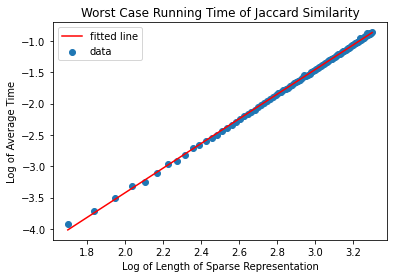

In [ ]:
plot_data_linregr(xs_jaccard, ys_jaccard2)

As expected, the slope of the average case is $1$, which means that its time complexity is $O(n)$. In the same way, the slope of the worst case is $1.96$, which approximates to $2$, thus leading to a time complexity of $O(n^2)$.

# Question 2: Cosine Similarity (Dense Representation)

Create a dense representation.

In [ ]:
# Functions from lab 8
def dense_representation(documents):

  allfeatures = {}    
  for docdict in documents:
      for feat in docdict.keys():
          allfeatures[feat]=1 
  dimensions = list(allfeatures.keys())
  dimensions = sorted(dimensions)

  matrix = []
  #each row in the matrix will be one of the dimensions
  # for dimension in news_text:
  for dimension in dimensions:
    row = []
    #look up the appropriate value for each document
    for doc in documents:
      row.append(doc.get(dimension,0)) #this will append the document's value if present, 0 otherwise
    matrix.append(row)
      
  transposed = []
  for i in range(0,len(matrix[0])):
      transposed.append([row[i] for row in matrix])
      
  return transposed

$$Cos(A, B) = \cfrac{A\cdot B}{\sqrt{A\cdot A}\sqrt{B\cdot B}}$$

The worst case running time for the cosine similarity using a dense representation is $O(n)$. Since there is always a for loop to calculate the dot product, the time complexity is always the same. TO calculate the dot product, there is an iteration over all the elements of one of the vectors because, since all vectors in the dense representation have the same dimension (which is equal to the total number of different words present in all documents), it is no needed to iterate over both vectors. Thus, it is only required one loop to do that and, becasue of that, the time complexity remains always linear.   

In [ ]:
def dot_dense(v1,v2):
    total=0
    # Time complexity for the dot product computed with a for loop is O(v1).
    for i in range(len(v1)):
        total += v1[i] * v2[i]
        
    return total

def cosine_similarity_dense(v1,v2):
    # Since time complexity of 'dot' function is O(v), and it is called 3 times 
    # (once in the numerator and twice in the denominator), the time complexity 
    # for the cosine similarity is O(3v). Thus, without loss of generality,
    # time complexity is linear: O(v). This time complexity is always the same,
    # matter the input vector. 
    return dot_dense(v1,v2) / np.sqrt(dot_dense(v1,v1) * dot_dense(v2,v2))

Create  different dense representations of different sizes to test the running time as the their size increases.

In [ ]:
vectors_news = [dense_representation([d]) for d in docs_news]

Measure running time of Cosine similarity between different dense representations length.

In [ ]:
times_cosine = []
for ind in range(len(docs_news)):
  times_cosine.append(timeit(cosine_similarity_dense, vectors_news[ind][0], vectors_news[ind][0])[1])

Plot running times for Cosine similarity.

In [ ]:
xs_cosine = [len(d) for d in docs_news]
ys_cosine = times_cosine

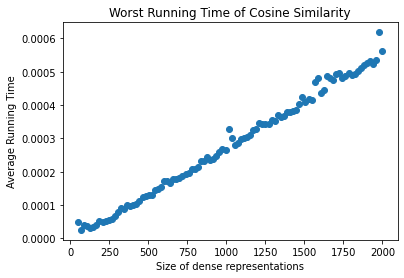

In [ ]:
plt.scatter(xs_cosine,ys_cosine)
plt.title('Worst Running Time of Cosine Similarity')
plt.xlabel('Size of dense representations')
plt.ylabel('Average Running Time')
plt.show()

As done with Jaccard similarity, it is assumed the same function and it is also transformed into logarithms to calculate the slope and the constant.

Using linear regression from scipy.stats:
Slope = 1.0058590673337204
Intercept = -6.585797578811607


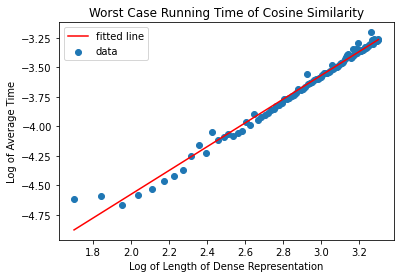

In [ ]:
plot_data_linregr(xs_cosine,ys_cosine,type_repr='Dense',similarity='Cosine')

Using numpy.dot to compute the dot product in the cosine similarity to see any running time difference between each implementation. 

In [ ]:
def cosine_similarity_numpy(v1,v2):
  v1 = np.array(v1)
  v2 = np.array(v2)
  return np.dot(v1,v2) / (np.sqrt(np.dot(v1,v1)) * np.sqrt(np.dot(v2,v2)))

Measure running time of Cosine similarity between different dense representations length using numpy.dot.

In [ ]:
times_cosine_numpy = []
for ind in range(len(docs_news)):
  times_cosine_numpy.append(timeit(cosine_similarity_numpy, vectors_news[ind][0], vectors_news[ind][0])[1])

Plot running times for Cosine similarity.

In [ ]:
xs_cosine_numpy = [len(d) for d in docs_news]
ys_cosine_numpy = times_cosine_numpy

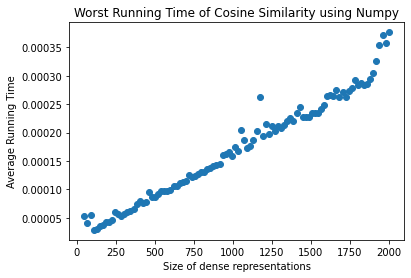

In [ ]:
plt.scatter(xs_cosine_numpy,ys_cosine_numpy)
plt.title('Worst Running Time of Cosine Similarity using Numpy')
plt.xlabel('Size of dense representations')
plt.ylabel('Average Running Time')
plt.show()

Compute the slope and intercept using my implementation and scipy.stats.

Using linear regression from scipy.stats:
Slope = 0.7510793831878319
Intercept = -6.022141582930127


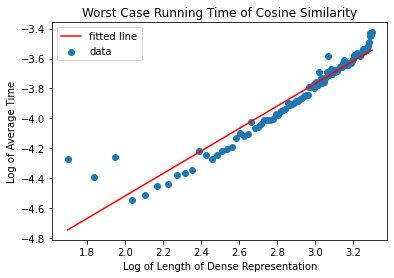

In [ ]:
plot_data_linregr(xs_cosine_numpy,ys_cosine_numpy,type_repr='Dense',similarity='Cosine')

Comparing the average running time between cosine similarity with and without using the numpy library. 

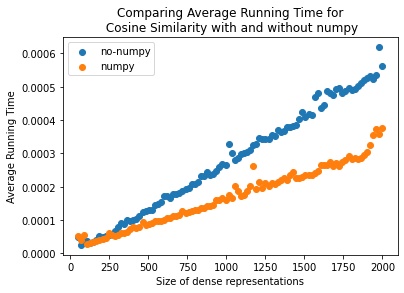

In [ ]:
plt.scatter(xs_cosine, ys_cosine, label='no-numpy')
plt.scatter(xs_cosine_numpy, ys_cosine_numpy, label='numpy')
plt.title('Comparing Average Running Time for\n Cosine Similarity with and without numpy')
plt.xlabel('Size of dense representations')
plt.ylabel('Average Running Time')
plt.legend(loc='best')
plt.show()

As can be seen, using numpy.dot is faster than using a loop. In particular, the time complexity for the cosine similarity using numpy.dot is $O(n^{0.75})$, which, I assume that for larger documents it tends to $O(n)$.

# Question 3: Cosine Similarity (Sparse Representation)

Computing cosine similarity using a sparse representation (dictionaries) instead of a dense representation (vectors) involves similar operations. Again, the function that defines the time complexity is the one that computes the dot product between each vector. However, in this case, instead of accessing the value of each vector (entering its index), it is used the 'get' method. Now the loop iterates over all values of one of the documents and, each value is multiplied by the value of the second document corresponding to the actual key. 

Contrary to the dense representation case, the worst case running time now  is $O(n^2)$. Although the algorithm is the same in both cases, the differencce is due to the 'get' method used, since its worst case running time is $O(n)$. Similarly as for Jaccard's similarity with the 'in' operator, the worst case running time is $O(n^2)$. 

In [ ]:
"""
Sparse representation
"""

def cosine_similarity_sparse(doc1,doc2):
  """
  computes the cosine similarity betweeen two documents
  """
  return dot_sparse(doc1,doc2) / math.sqrt(dot_sparse(doc1,doc1) * dot_sparse(doc2,doc2))
        
def dot_sparse(vecA,vecB):
  """
  computes the dot product between two vectors
  """
  the_sum = 0
  for (key,value) in vecA.items():
      the_sum += value * vecB.get(key,0)
      
  return the_sum

In [ ]:
times_cosine_sparse = []
for ind in range(len(docs_news)):
  times_cosine_sparse.append(timeit(cosine_similarity_sparse, docs_news[ind], docs_news[ind])[1])

In [ ]:
xs_cosine_sparse = [len(d) for d in docs_news]
ys_cosine_sparse = times_cosine_sparse

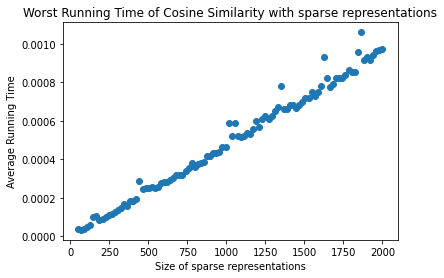

In [ ]:
plt.scatter(xs_cosine_sparse, ys_cosine_sparse)
plt.title('Worst Running Time of Cosine Similarity with sparse representations')
plt.xlabel('Size of sparse representations')
plt.ylabel('Average Running Time')
plt.show()

Using linear regression from scipy.stats:
Slope = 1.0007843046329903
Intercept = -6.319622360109933


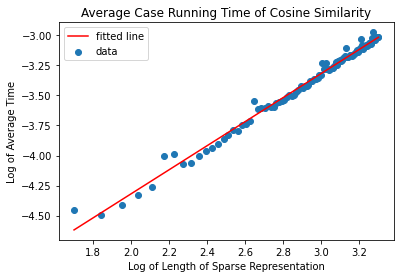

In [ ]:
plot_data_linregr(xs_cosine_sparse,ys_cosine_sparse,case='Average',similarity='Cosine')

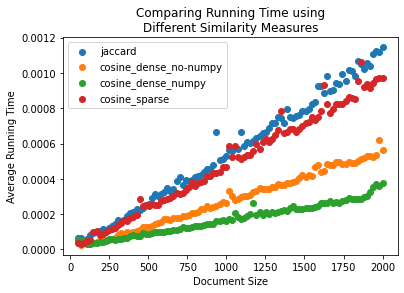

In [ ]:
plt.scatter(xs_jaccard, ys_jaccard, label='jaccard')
plt.scatter(xs_cosine_numpy, ys_cosine, label='cosine_dense_no-numpy')
plt.scatter(xs_cosine_numpy, ys_cosine_numpy, label='cosine_dense_numpy')
plt.scatter(xs_cosine_numpy, ys_cosine_sparse, label='cosine_sparse')
plt.title('Comparing Running Time using\nDifferent Similarity Measures')
plt.xlabel('Document Size')
plt.ylabel('Average Running Time')
plt.legend(loc='best')
plt.show()

# Question 4: All-pairs Similarities

As explained above, the worst case running time for computing the similarity between two documents represented as dictionaries (sparse representation) is $O(n)$ for both jaccard and cosine similarities. When the documents are encoded as vectors (dense representations), the time complexity is $O(n^2)$ for cosine similarity without using numpy, and $O(n^{0.7})$ when using numpy (although it is assumed that it will tend to 1 for larger documents). 

The time complexity of the function 'all_pairs_similarities' is $O(n^2)$ (to compare all documents it is needed a nested loop). However, the $n$ of the similarities refers to the document size (i.e., number of words) and not to the number of documents. Thus, in this function we are dealing with two different variables: the number of documents and the number of words per document.  Then, the precise ways of representing the worst case running time for each algorithm are the followings:

$$Jaccard: O(n^2\cdot w^2)$$
$$Cosine_{dense}: O(n^2\cdot w)$$
$$Cosine_{numpy}: O(n^2\cdot w^{0.7})$$
$$Cosine{sparse}: O(n^2\cdot w)$$

where $n$ refers to the number of documents and $w$ to the number of words per document. 

On average, it is possible to neglect the value of $w$ and consider only the variable $n$, since $w$ becomes meaningless as n gets arbitrarily large. However, the worst case running time is defined by the scenario in which $w$ tends to infinity. Here, time complexity for each algorithm is the one defined above, where both the value of $n$ and $w$ are taken into account. 

In [ ]:
def all_pairs_similarities(docs,similarity):
  aps = []
  if similarity == 'jaccard':
    sim = jaccard_similarity
  elif similarity == 'cosine_dense':
    sim = cosine_similarity_dense
    docs = dense_representation(docs)
  elif similarity == 'cosine_dense_np':
    sim = cosine_similarity_numpy
    docs = dense_representation(docs)
  elif similarity == 'cosine_sparse':
    sim = cosine_similarity_sparse
  else:
    return print('Invalid similarity')

  for doc1 in docs:
    for doc2 in docs:
      aps.append(sim(doc1,doc2))
  return aps

In [ ]:
samples = list(map(int, np.linspace(2, 100, 20)))
docs_news3_samples = [random.sample(docs_news,s) for s in samples]

In [ ]:
times_allpairs_jaccard = []
times_allpairs_cosdense = []
times_allpairs_cosnp = []
times_allpairs_cossparse = []

for docs in docs_news3_samples:
  times_allpairs_jaccard.append(timeit(all_pairs_similarities, docs, 'jaccard',repeats=2)[1])
  times_allpairs_cosdense.append(timeit(all_pairs_similarities, docs, 'cosine_dense',repeats=2)[1])
  times_allpairs_cosnp.append(timeit(all_pairs_similarities, docs, 'cosine_dense_np',repeats=2)[1])
  times_allpairs_cossparse.append(timeit(all_pairs_similarities, docs, 'cosine_sparse',repeats=2)[1])

In [ ]:
xs = [len(d) for d in docs_news3_samples]

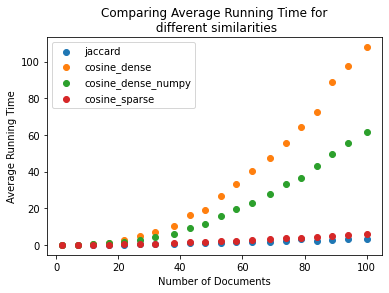

In [ ]:
plt.scatter(xs, times_allpairs_jaccard, label='jaccard')
plt.scatter(xs, times_allpairs_cosdense, label='cosine_dense')
plt.scatter(xs, times_allpairs_cosnp, label='cosine_dense_numpy')
plt.scatter(xs, times_allpairs_cossparse, label='cosine_sparse')
plt.title('Comparing Average Running Time for\n different similarities')
plt.xlabel('Number of Documents')
plt.ylabel('Average Running Time')
plt.legend(loc='best')
plt.show()

Using linear regression from scipy.stats:
Slope = 2.066067494162526
Intercept = -3.5412300992762744


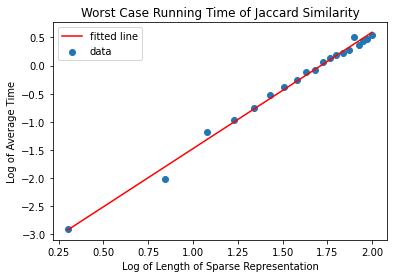

Using linear regression from scipy.stats:
Slope = 2.727923187531905
Intercept = -3.3225900288243184


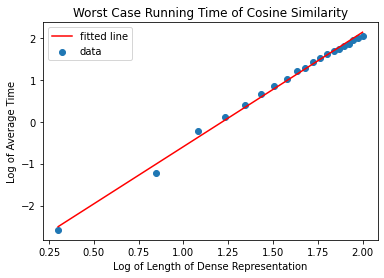

Using linear regression from scipy.stats:
Slope = 2.663432018874738
Intercept = -3.4465314408121346


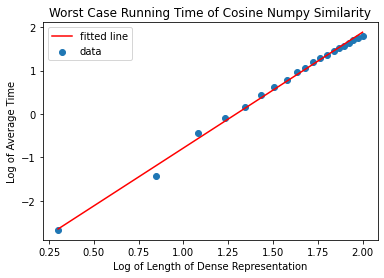

Using linear regression from scipy.stats:
Slope = 2.170354927109239
Intercept = -3.488046436155394


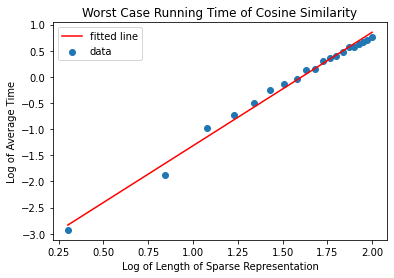

In [ ]:
plot_data_linregr(xs,times_allpairs_jaccard)
plot_data_linregr(xs,times_allpairs_cosdense,'Dense','Cosine')
plot_data_linregr(xs,times_allpairs_cosnp,'Dense','Cosine Numpy')
plot_data_linregr(xs,times_allpairs_cossparse,'Sparse','Cosine')

As done before: $$log(f(x))=log(c)+b\cdot log(x)$$
 where x is the number of documents. In this case, we are evaluating the time complexity for 200.000 documents. 

For **Jaccard's** similarity, $b = 2$ and $c= 10^{-3.54}$

Thus, the aproximate running time for 200.000 documents is

$$RunningTime_{Jaccard} = 10^{-3.54}\times 200.000^2 = 1335 \; days$$

In the case of **Cosine** simmilarity using a **dense representation**, $b = 2.72$ and $c= 10^{-3.32}$, we obtain

$$RunningTime_{cosinedense}  = 10^{-3.32}\times 200,000^{2.72}= 39810 \; years $$

For **Cosine** simmilarity using a **dense representation and numpy**, $b = 2.66$ and $c= 10^{-3.44}$, it is obtained

$$RunningTime_{cosinenp}  = 10^{-3.44}\times 200,000^{2.66}= 14720 \; years $$

Finally, for **Cosine** simmilarity using a **sparse representation**, $b = 2.17$ and $c= 10^{-3.48}$ the result is

$$RunningTime_{cosinesparse}  = 10^{-3.48}\times 200,000^{2.17}= 12210 \; days $$


As can be seen, there can be a huge difference in running time depending on the algorithm chosen. Since the function  'all_pairs_similarities' takes as input a collection of documents (list of dictionaries), it is expected that the algorithms that uses sparse representations will be faster, since they do not have to convert this collection to a dense representation. 

# Question 5: Map-Reduce

Using the map-reduce computing paradigm it can be obtained cosiderably higher speed. The key for this implementation To reach that performance level, it is crucial to use map-reduce twice. In the first map-reduce, it is created the inverted index; and in the second, the inverted index is used to calculate the pairwise similarity.

The first mapper function creates a dictionary for each word (key) of the input document along with its frequency (value). Then it has to be added to the value an index for each document in order to link each word to the document it belongs to. After that, both are reduced, thus resulting in the inverted index that links frecuenncies and document indices to words. 

On the other hand, the second mapper function creates a tuple composed of two document indexes and a word count that defines the relationships between the two documents. The reducer clusters the data according to the key, in order to obtain all-pairs similarity.

In [ ]:
# functions from lab 7
def wc_mapper_parallel(documents):
  output = []
  for i in range(len(documents)):
    document = {}
    for word in documents[i]:
      value = document.get(word,0)
      if value == 0:
        document[word] = (i,document.get(word,0) + 1)
      else:
        document[word] = (i,document.get(word)[1] + 1)
    output.append(document)

  return output

def wc_reducer_parallel(mapped_items):
  output = {}
  for item in mapped_items:
    for key,value in item.items():
      output[key] = []   

  for item in mapped_items:
    for key,value in item.items():
      for key1,value1 in output.items():
        if key == key1:
          output[key1].append(value)

  return output

In [ ]:
def dictionary_to_list_strings(documents):
  """
  Given a set of documents stored as sparse representations
  (i.e., frrequency dictionaries), returns documents as a list of strings
  """
  docs_as_strings = []
  for doc in documents: 
    get_str = "" 
    for word,freq in doc.items(): 
      get_str += word
      get_str += " "
    docs_as_strings.append(get_str) 
  return docs_as_strings

lists_strings = dictionary_to_list_strings(docs_news)
lists_tokens = []     
for x in range(len(lists_strings)):
  lists_tokens.append(word_tokenize(lists_strings[x]))  
print(lists_tokens)

[['credencive', 'viriliously', 'unexacerbated', 'subahdar', 'coresidence', 'discommodiously', 'answerlessly', 'Jewy', 'pneumotropic', 'lamziekte', 'semihistorical', 'novation', 'vis', 'dammar', 'brethren', 'orangism', 'schistosomiasis', 'unplanted', 'uncompanioned', 'underrogue', 'proboscideous', 'falces', 'paraphysate', 'extractorship', 'epicardium', 'composita', 'Anamnia', 'aortoclasia', 'cleanup', 'tombal', 'pharyngoplegia', 'glutenin', 'foredoomer', 'Mordvin', 'autoelectrolytic', 'newfangled', 'untemptingly', 'suppression', 'considerable', 'Primus', 'payeny', 'Peridiniales', 'hyperrational', 'unexcusableness', 'brochette', 'agy', 'shure', 'choana', 'unreeve', 'dibs'], ['quotational', 'tangentially', 'antievangelical', 'burnisher', 'rigmaree', 'meandrine', 'trypsin', 'scaturient', 'Chouan', 'corkiness', 'trochilic', 'testaceology', 'profitproof', 'hinney', 'stunsle', 'Mayflower', 'warren', 'abdominohysterotomy', 'valonia', 'theanthropos', 'pseudopelletierine', 'cementer', 'tirade', 

In [ ]:
map_results = wc_mapper_parallel(corpus)
inv_index = wc_reducer_parrallel(mappedResults)

In [ ]:
"""
Code from the Applied Natural Language Processing  module to count the number of words written
"""

import io
from nbformat import current

filepath="/content/drive/My Drive/Sussex AI/Algorithmic Data Science/Assignment/ADS Assignment.ipynb"
question_count=325

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1156
